In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output as clr
from sklearn.cluster import MiniBatchKMeans as MBKMeans
from sklearn.neural_network import MLPClassifier as mlp 
import os
import numpy as np
import time
torch.autograd.set_detect_anomaly(True)

In [2]:
# training
BATCH_SIZE = 100
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
if(os.path.isdir(os.path.join(os.getcwd(), '../data/cifar-10-batches-py'))):
    trainset = datasets.CIFAR10('../data/', train=True, download=False,
                   transform=transform)
else:
    trainset = datasets.CIFAR10('../data/', train=True, download=True,
                   transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data/', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

print("Done !")

Done !


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [13]:
class DeepCluster(nn.Module):
    
    def __init__(self, K):
        super(DeepCluster, self).__init__()
        
        self.K = K
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 84)
        )
        
        self.fc_last = nn.Linear(84, self.K)
        
        with torch.no_grad():
            self.C = None
            self.K_lr = 0.001
            self.loss = F.cross_entropy
            self.loss2 = nn.MSELoss()
            self.clustering = MBKMeans(n_clusters = self.K)
            self.count = [0]*self.K
        
    
    def forward(self, input):
        
        x = input
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        g = self.fc_layer(x)
        x = self.fc_last(g)
    
        return x, g

    def get_counts(self, labels):
        
        bins = [0]*self.K
        for l in list(labels.detach().numpy()):
            bins[l] += 1
        return bins
        
    def cluster_feats(self, feats, update = True):
        for i in range(50):
            with torch.no_grad():
                N ,K = feats.shape
                ### Implementation of Kmeans clustering
                if(self.C is None):
                    self.C = feats[:self.K,:].view(self.K, K)

                # Finding nearest assigments..
                x_lazy = feats.view(N, 1, K)
                c_lazy = self.C.view(1, self.K, K)
                D = ((x_lazy - c_lazy)**2).sum(-1)
                labels = D.argmin(dim=1).view(-1)
                Nc = self.get_counts(labels)

                if(update):
                    c = self.C[:,:]
                    for k in range(self.K):
                        if(Nc[k] == 0):
                            self.count[k] += 1
                            if(self.count[k] >= 10):
                                self.count[k] = 0

                                maxind = 0
                                for ind in range(self.K):
                                    if(Nc[ind] > Nc[maxind]):
                                        maxind = ind


                                c[k,:] = c[maxind,:]+torch.rand_like(c[maxind,:])*10e-20               
                        else:
                            pass

                    # Finding nearest assigments..
                    c_lazy = c.view(1, self.K, K)
                    D = ((x_lazy - c_lazy)**2).sum(-1)
                    labels = D.argmin(dim=1).view(-1)

                    Nc = self.get_counts(labels)
                    for k in range(self.K):
                        if(Nc[k] == 0):
                            pass
                        else:
                            vec = feats[labels == k].view(-1,K)
                            c[k,:] = vec.sum(0)/Nc[k]

                        self.C = self.K_lr*(c) + (1-self.K_lr)*self.C
                        temp = self.C.pow(2).sum(1).pow(1/2).view(-1,1)
    #                     self.C = self.C/temp
                

        return labels.long(), Nc
    
    def get_loss_old(self, x, cluster_update = True):
        
        out, feats = self.forward(x)
#         temp = feats.pow(2).sum(1).pow(1/2).view(-1,1)
#         feats = feats/temp
        with torch.no_grad():
            plabels, Nc = self.cluster_feats(feats.clone().detach(), cluster_update)
        
        wts = 1/(torch.tensor(Nc).float()+10e-4)
        wts = wts/wts.sum()
        loss = self.loss(out, plabels, weight = wts)# + self.loss2(temp, torch.zeros_like(temp) + 1)
        
        return loss
    
    def get_loss(self, x, cluster_update = True):
        
        out, feats = self.forward(x)
        temp = feats.pow(2).sum(1).pow(1/2).view(-1,1)
#         feats = feats/temp
        if(cluster_update):
            self.clustering.partial_fit(feats.clone().detach())
        plabels = torch.tensor(self.clustering.predict(feats.clone().detach())).view(-1).long()
        loss = self.loss(out, plabels) + self.loss2(temp, torch.zeros_like(temp) + 1)
        
        return loss

In [14]:
device = 'cpu'
model = DeepCluster(20)

In [15]:
opt = torch.optim.Adam(model.parameters(), 0.001)
train_loss = []
times = []

Epoch no : 4 batch_no : 490 curr_loss : 1.2648959  time_e: 2111.3507630825043


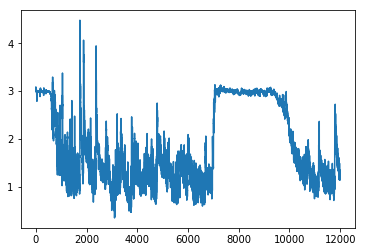

In [71]:
start = time.time()
plabels = []
model.K_lr = 0.1
for epoch in range(4):
    
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        opt.zero_grad() 
        
#         x, g = model.forward(images)
#         l = model.loss(x, labels)
        if(i%2 == 0):
            l = model.get_loss_old(images)
        else:
            l = model.get_loss_old(images, False)
            l.backward()
            opt.step()
    
        train_loss.append(l.detach().numpy())
        times.append(time.time() - start)
        
        if(i%10 == 0):
            clr(wait = True)
            print("Epoch no :", epoch + 1, "batch_no :", i, "curr_loss :",  train_loss[-1], ' time_e:', time.time() - start)
        
plt.plot(train_loss)
plt.show()

In [72]:
x,g = model.forward(images)

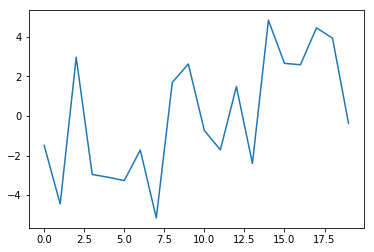

In [73]:
plt.plot(x.detach().numpy()[7])

In [74]:
np.unique(labels, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 6, 14,  8, 11,  9, 12, 10,  8, 13,  9]))

In [75]:
# ls = model.clustering.predict(g.detach().numpy())
ls, g = model.cluster_feats(g.detach())
np.unique(ls, return_counts = True)

(array([ 0,  2,  9, 11, 13, 14, 15, 16, 17, 18, 19]),
 array([ 4,  8,  3,  7,  7,  5, 40,  7,  5,  2, 12]))

In [76]:
ls

tensor([15, 15, 15, 19, 11, 15,  9, 17, 13, 15, 16, 16, 15, 16, 19,  0, 15, 18,
         0, 11, 15, 15, 19, 15, 17, 17, 19, 11, 19, 15, 16, 13,  2, 18,  9,  2,
        13, 15, 19, 15, 17, 19, 15, 15, 11, 15,  2, 15,  0, 19,  2,  2, 15, 15,
        19, 14, 15, 16, 15, 15, 19, 16, 13, 14, 15,  2, 15, 19, 14, 15, 15, 15,
        14, 19, 15, 11, 15, 11,  0, 15, 15, 15, 11, 13, 17, 13, 15, 15, 16,  2,
        15,  2, 14, 15,  9, 15, 13, 15, 15, 15])

In [77]:
labels[labels == 9]

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9])

In [78]:
cfier = mlp(hidden_layer_sizes=(32)) 

In [68]:
for i, data in enumerate(trainloader, 0):
        images, labels = data
        images = images.to(device)
        x, g = model.forward(images)
        x_train = g.detach().numpy().reshape(BATCH_SIZE, -1)
        y_train = labels.detach().numpy().reshape(BATCH_SIZE,)
        
        cfier.partial_fit(x_train, y_train, np.arange(10))

In [69]:
scores = []
for i, data in enumerate(testloader, 0):
        images, labels = data
        images = images.to(device)
        x, g = model.forward(images)
        x_test = g.detach().numpy().reshape(BATCH_SIZE, -1)
        y_test = labels.detach().numpy().reshape(BATCH_SIZE,)
        
        scr = cfier.score(x_test, y_test)
        scores.append(scr)

In [70]:
np.mean(scores)

0.10049999999999999